# Orbital Mechanics and Control
## Import Packages

In [56]:
import orbit
from satellite import Satellite
from dynamics import equation_of_motion
from plots import *

import numpy as np
from scipy.integrate import ode, DOP853
from math import pi

## Input variables
Initialize Orbit using one of the following methods:
- Classical Elements
- State Vector

If necessary, implement the conversion to State Vector for the following:
- Delaunay Elements
- Equinoctial Elements

These functionalities should be added from the Orbit abstract class in orbit.py

In [57]:
# Curtis - Example 4.3
ra = [-266.77,+3865.8,+5426.2]
va = [-6.4836,-3.6198,+2.4156]
rb = [-5890.7,-2979.8,+1792.2]
vb = [0.93583,-5.2403,-5.5009]

orbit0 = orbit.OrbitStateVector(ra,va)
orbit1 = orbit.OrbitStateVector(rb,vb)

R, mu = orbit0.get_central_body()       # Get central body according to orbit

orbit0.activate_perturbation([])  # Select perturbations
orbit1.activate_perturbation([])  # Select perturbations

sat0 = Satellite(orbit0,mass=100,cd=2.2,area=pi*0.5**2,name="Leader")
sat1 = Satellite(orbit1,mass=100,cd=2.2,area=pi*0.5**2)

satellites = [sat0, sat1]

## Time setup

In [58]:
# Define simulation time in seconds
t0        = 0
time_end  = 3600*24*4
time_step = 60
times     = np.arange(0,time_end,step=time_step)

## Linear Control

In [59]:
# Tune control law used
Kp = 0
Ki = 0
Kd = 0

## Simulation

In [60]:
# Simulate orbit
from typing import List
first = ode(equation_of_motion)
second = ode(equation_of_motion)
list_solver = [first, second]

for sat, solver in zip(satellites,list_solver):
    solver.set_integrator('DOP853')
    solver.set_f_params(sat.get_orbit(),sat)
    solver.set_initial_value(sat.get_orbit().get_initial_state(),t0)
    
for time in times:
    for sat,solver in zip(satellites,list_solver):
        solver.integrate(time)

        sat.save_state(solver.y)

/home/msb/Codes/PY/orbital-mechanics/env/lib/python3.10/site-packages/scipy/integrate/_ode.py:431: UserWarning: dop853: step size becomes too small
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


## Plots

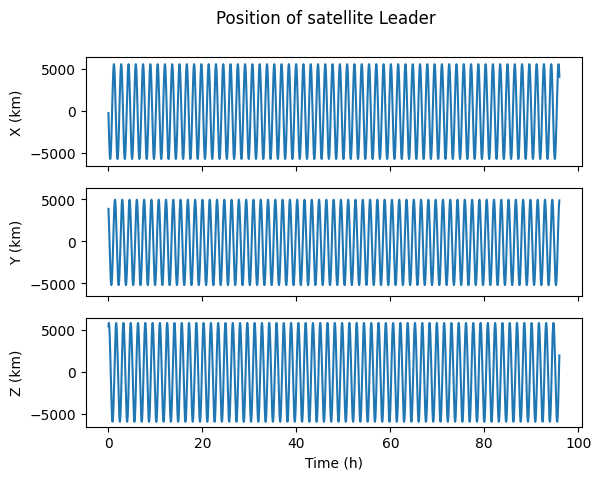

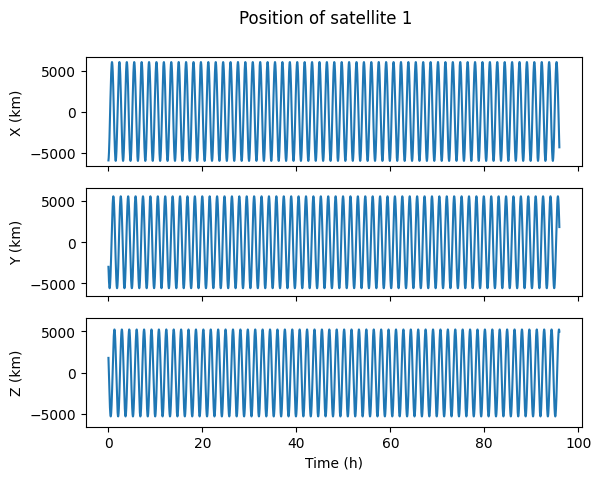

In [61]:
plot_position(satellites,times)

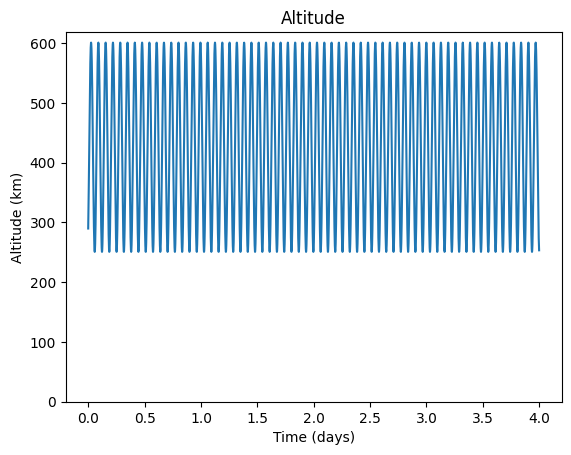

In [62]:
plot_altitude(satellites[0],times,R)

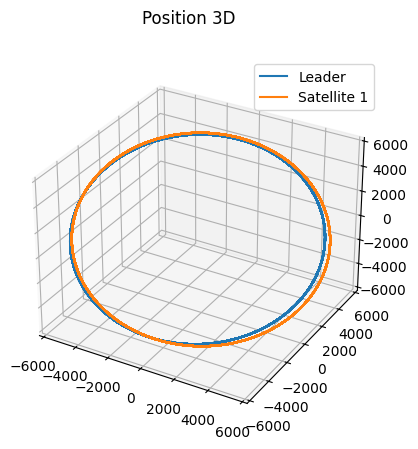

In [63]:
plot3d(satellites,times)

/tmp/ipykernel_15672/3164732079.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  tri.show()


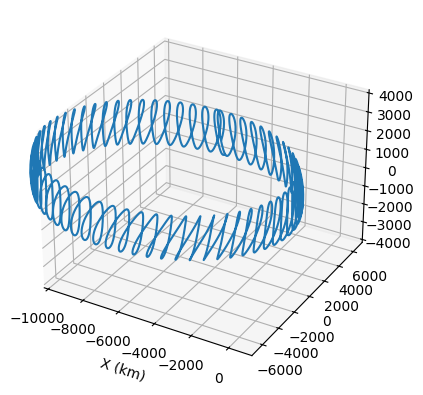

In [74]:
X0,Y0,Z0,Vx0,Vy0,Vz0 = sat0.get_state()
X1,Y1,Z1,Vx1,Vy1,Vz1 = sat1.get_state()
x_rel = [];y_rel = []; z_rel = []
vx_rel = [];vy_rel = []; vz_rel = []

for idx in range(len(times)):
    rA = [X0[idx],Y0[idx],Z0[idx]]
    vA = [Vx0[idx],Vy0[idx],Vz0[idx]]
    rB = [X1[idx],Y1[idx],Z1[idx]]
    vB = [Vx1[idx],Vy1[idx],Vz1[idx]]
    
    rA_norm = np.sqrt(X0[idx]**2+Y0[idx]**2+Z0[idx]**2)

    hA = np.cross(rA,vA)
    i = rA / rA_norm
    k = hA / np.sqrt(hA[0]**2+hA[1]**2+hA[2]**2)
    j = np.cross(k,i)

    Q = [i,j,k]

    Omega = hA/rA_norm**2
    dOmega = (-2 / rA_norm**2) * np.dot(np.dot(vA,rA),Omega)

    r_rel_ECI = np.subtract(rB, rA)
    v_rel_ECI = np.subtract(np.subtract(vB, vA),np.cross(Omega,r_rel_ECI))

    r_rel_LVLH = Q @ r_rel_ECI
    v_rel_LVLH = Q @ v_rel_ECI

    x_rel.append(r_rel_LVLH[0])
    y_rel.append(r_rel_LVLH[1])
    z_rel.append(r_rel_LVLH[2])
    vx_rel.append(v_rel_LVLH[0])
    vy_rel.append(v_rel_LVLH[1])
    vz_rel.append(v_rel_LVLH[2])


/tmp/ipykernel_15672/1427691215.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  tri.show()


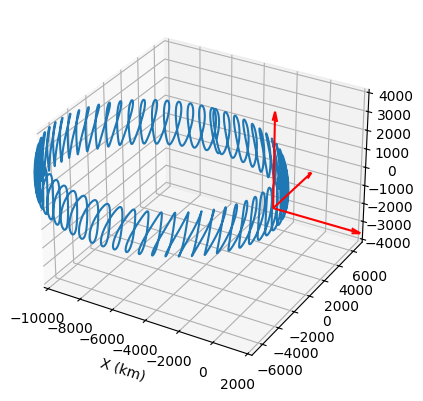

In [81]:

tri = plt.figure(33)
ax = tri.add_subplot(111,projection='3d')
ax.plot(x_rel,y_rel,z_rel)
ax.set_xlabel("X (km)")
ax.set_xlim([-10000,2000])
ax.set_ylim([-7000,7000])
ax.set_zlim([-4000,4000])

# Draw X-axis arrow
ax.quiver(0, 0, 0, 1, 0, 0, color='r', label='X', length=5000, arrow_length_ratio=.1)
# Draw Y-axis arrow
ax.quiver(0, 0, 0, 0, 1, 0, color='r', label='Y', length=5000, arrow_length_ratio=.1)
# Draw Z-axis arrow
ax.quiver(0, 0, 0, 0, 0, 1, color='r', label='Z', length=5000, arrow_length_ratio=.1)

tri.show()